# Data Engineering for Other People

### Or: Why is this software engineer being such a diva?

So you've got some data. In my case, I've been keeping track of how successful my taco truck has been.

![Taco Sales.xlsx](./images/taco-sales-xlsx.png)

Nothing crazy, a date column, how many of each kind of taco I sold, and where I parked my taco truck that day.
At this point, I'd like to create some sweet visualizations of my data, to better understand the fundamentals of my taco truck business. I know a little python, and I've heard it's good at this kind of thing, so I fire up a jupyter notebook and import it into a pandas dataframe.

In [1]:
import pandas as pd
from matplotlib import cm

pd.options.display.max_rows = 7

df = pd.read_excel('./versions/Taco Sales - v1.xlsx')
df

,Unnamed: 0,Tacos,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,Date,Beef,Chicken,Pork,Location
1,2021-04-01 00:00:00,4,5,4,Golden
2,2021-04-02 00:00:00,3,5,3,Aurora
...,...,...,...,...,...
12,2021-04-12 00:00:00,2,3,4,Denver
13,2021-04-13 00:00:00,one,7,55,Denver
14,2021-04-14 00:00:00,0,3,5,Denver


Wow, that's not what I was expecting.

Leaving aside the column headings, those dates aren't what I'm seeing in Excel at all!

The usual solution to problems like this is "plain text", but Excel files don't work like that at all. Luckily, they can be converted to "csv"s, or Comma Separated Values, which are plain text, and can be viewed in a text editor to make sure your data is exactly what you expect it to be. To convert, click "save as" and then pick "CSV" from the list of dropdown options. You end up with something you can open in TextEdit that looks like this:

![Taco Sales.csv](./images/taco-sales-csv.png)

Not exactly the most readable thing in the world, but at least you can see exactly what your data looks like.

Let's re-import that into pandas.

In [2]:
df = pd.read_csv('./versions/Taco Sales - v1.csv')
df

,Unnamed: 0,Tacos,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,Date,Beef,Chicken,Pork,Location
1,4/1,4,5,4,Golden
2,4/2,3,5,3,Aurora
...,...,...,...,...,...
12,4/12,2,3,4,Denver
13,4/13,one,7,55,Denver
14,4/14,0,3,5,Denver


That matches what we see in TextEdit, great!

Now, that tacos row isn't doing us any favors. Pandas is trying to use it as the "header row", but the only useful piece of information in it is the word "tacos", and it's pushing our actual column labels into our data. Let's delete that.

In [3]:
df = pd.read_csv('./versions/Taco Sales - v2.csv', index_col='Date')
df

,Beef,Chicken,Pork,Location
Date,,,,
4/1,4,5,4,Golden
4/2,3,5,3,Aurora
4/3,one,three,five,Golden
...,...,...,...,...
4/12,2,3,4,Denver
4/13,one,7,55,Denver
4/14,0,3,5,Denver


Now we're cooking! I think we're ready to plot our sales...

In [4]:
df[['Beef', 'Chicken', 'Pork']].plot(colormap=cm.Paired)

TypeError: no numeric data to plot

Oh no!

If we google this error message, we find that there's a pandas function `to_numeric` that might help us, but as you can see, that has its own problems.

<AxesSubplot:xlabel='Date'>

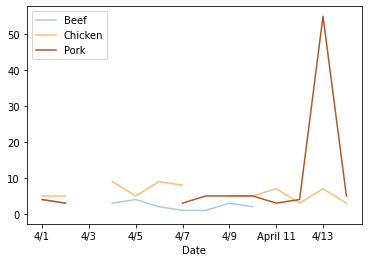

In [5]:
df['Beef'] = pd.to_numeric(df['Beef'], errors='coerce')
df['Chicken'] = pd.to_numeric(df['Chicken'], errors='coerce')
df['Pork'] = pd.to_numeric(df['Pork'], errors='coerce')

df[['Beef', 'Chicken', 'Pork']].plot(colormap=cm.Paired)

Our chart has holes in it!

The only way to fix this is to back to the source, and make sure that we consistently write our numbers as numbers, and not as their english equivalent. "1" not "one", "0" not "-"!

<AxesSubplot:xlabel='Date'>

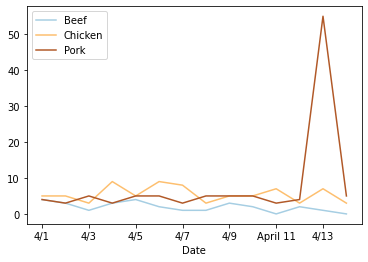

In [6]:
df = pd.read_csv('./versions/Taco Sales - v3.csv', index_col='Date')
df[['Beef', 'Chicken', 'Pork']].plot(colormap=cm.Paired)

And we should probably do the something similar to the Date column so that we don't see that random "April 11".

<AxesSubplot:xlabel='Date'>

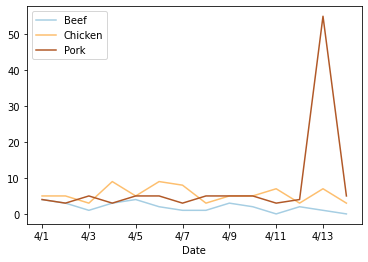

In [7]:
df = pd.read_csv('./versions/Taco Sales - v4.csv', index_col='Date')
df[['Beef', 'Chicken', 'Pork']].plot(colormap=cm.Paired)

There's a weird spike on the 13th, but we'll come back to that later.

Now that I'm tracking how much I'm selling, it would be nice to know where I'm spending most of my time.

<AxesSubplot:>

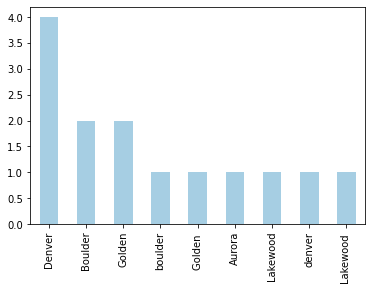

In [8]:
df['Location'].value_counts().plot(kind='bar', colormap=cm.Paired)

Well that's not helpful. Most of these cities are in there twice!

In [9]:
df['Location'].unique()

array(['Golden', 'Aurora', 'Golden ', 'Boulder', 'Denver', 'Lakewood ',
       'denver', 'boulder', 'Lakewood'], dtype=object)

The problem is that these values are not *exactly* the same. Inconsistent casing, or extra spaces make pandas treat them as separate labels.

This is another thing we need to clean up first.

In [10]:
df = pd.read_csv('./versions/Taco Sales - v5.csv', index_col='Date')
df['Location'].unique()

array(['Golden', 'Aurora', 'Boulder', 'Denver', 'Lakewood'], dtype=object)

<AxesSubplot:>

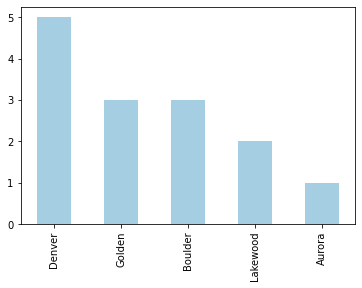

In [11]:
df['Location'].value_counts().plot(kind='bar', colormap=cm.Paired)

Perfect!

Another useful piece of information is weather data. That's in a separate tab in the excel file, so we'll export that as a csv and load it up.

In [12]:
weather_df = pd.read_csv('./versions/Weather - v1.csv')
weather_df = weather_df.fillna(method='ffill')
weather_df

,Week,Date,Weather
0,3/28,Thu,Cloudy
1,3/28,Fri,Sun
2,3/28,Sat,Sun
...,...,...,...
11,4/11,Mon,Wind
12,4/11,Tue,Sun
13,4/11,Wed,Sun


Pandas has a join method so we can connect that to our original dataset...

In [13]:
df.join(weather_df, how='outer')

,Beef,Chicken,Pork,Location,Week,Date,Weather
0,NaN,NaN,NaN,NaN,3/28,Thu,Cloudy
1,NaN,NaN,NaN,NaN,3/28,Fri,Sun
2,NaN,NaN,NaN,NaN,3/28,Sat,Sun
...,...,...,...,...,...,...,...
4/7,1.0,8.0,3.0,Denver,NaN,NaN,NaN
4/8,1.0,3.0,5.0,Boulder,NaN,NaN,NaN
4/9,3.0,5.0,5.0,Golden,NaN,NaN,NaN


Not so much.

Pandas needs an index to join on, and to actually match content, the index in both dataframes needs to be identical.

So another round of hand-editing, and we have a dataset we can join on.

In [14]:
weather_df = pd.read_csv('./versions/Weather - v2.csv', index_col='Date')
weather_df

,Weather
Date,
4/1,Cloudy
4/2,Sun
4/3,Sun
...,...
4/12,Wind
4/13,Sun
4/14,Sun


In [15]:
df = df.join(weather_df)
df

,Beef,Chicken,Pork,Location,Weather
Date,,,,,
4/1,4,5,4,Golden,Cloudy
4/2,3,5,3,Aurora,Sun
4/3,1,3,5,Golden,Sun
...,...,...,...,...,...
4/12,2,3,4,Denver,Wind
4/13,1,7,55,Denver,Sun
4/14,0,3,5,Denver,Sun


Now that we've joined both datasets, we can group the first one by weather, and see on average how many tacos we sell depending on the weather.

<AxesSubplot:xlabel='Weather'>

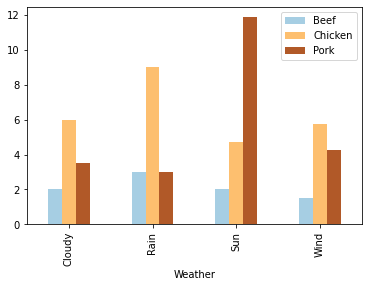

In [16]:
df[['Beef', 'Chicken', 'Pork', 'Weather']].groupby('Weather').mean().plot(kind='bar', colormap=cm.Paired)

Remember that weird spike in pork sales on the 13th we noticed earlier?

![Pork Spike](./images/pork-spike.png)

We can obviously see that there's something wrong with our data here, but with some datasets, the data engineer working with the data may not have the domain knowledge or context to recognize outliers. In situations like that, it's really helpful to provide them with a "codebook", or description of the dataset. In it, whoever put together the initial dataset can describe their data - the "weather" column should have labels like "sun", "rain", etc; pork sales should be an integer (no half tacos!) between 0 and 15; and so on.

You can ignore the code in the next cell, it's just going through and automatically generating a codebook off of our dataset.

In [17]:
df['Weather'] = df['Weather'].astype("category")
df['Location'] = df['Location'].astype("category")

desc_df = pd.DataFrame(index=['count', 'dtype', 'unique', 'top', 'freq', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
cats_df = pd.DataFrame()
labels = set()

for col in df.columns:
    df_col = df[col].describe().to_frame().astype('object')
    df_col.loc['dtype'] = df[col].dtype.name
    labels = labels | set(df_col.index.values)

    desc_df = desc_df.join(df_col, how='left')
    
    if df[col].dtype.name == 'category':
        df_cats = df[col].dtype.categories\
            .to_frame(name=col)\
            .reset_index(drop=True)
        cats_df = cats_df.join(df_cats, how='outer')
    
desc_df = desc_df.append(cats_df)
desc_df.to_csv('./codebook.csv')

The resulting codebook looks like this:

![Codebook](./images/codebook.png)

Can you see the problem? The maximum value in the "Pork" column is 55. Compared to both "Beef" and "Chicken" sales, but also the 75th percentile of "Pork" sales, that seems way out of wack.

If we go back to the original data, we can see a pretty obvious typo of "55" instead of "5".

![Too Much Pork](./images/too-much-pork.png)

Once we fix that, we can reload all of our data, join the two sheets together again, and get graphs and codebooks like we'd expect.

In [18]:
df = pd.read_csv('./versions/Taco Sales - v6.csv', index_col='Date')
weather_df = pd.read_csv('./versions/Weather - v2.csv', index_col='Date')
df = df.join(weather_df)
df

,Beef,Chicken,Pork,Location,Weather
Date,,,,,
4/1,4,5,4,Golden,Cloudy
4/2,3,5,3,Aurora,Sun
4/3,1,3,5,Golden,Sun
...,...,...,...,...,...
4/12,2,3,4,Denver,Wind
4/13,1,7,5,Denver,Sun
4/14,0,3,5,Denver,Sun


<AxesSubplot:xlabel='Date'>

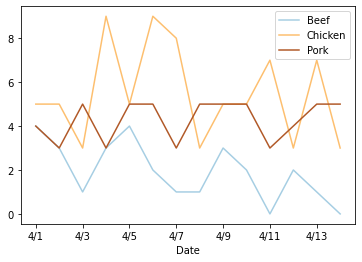

In [19]:
df[['Beef', 'Chicken', 'Pork']].plot(colormap=cm.Paired)

<AxesSubplot:xlabel='Weather'>

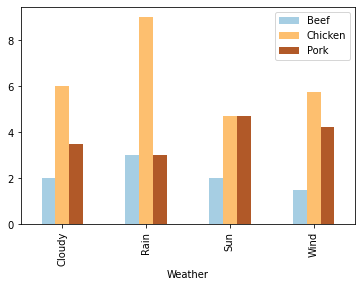

In [20]:
df[['Beef', 'Chicken', 'Pork', 'Weather']].groupby('Weather').mean().plot(kind='bar', colormap=cm.Paired)

In [21]:
df['Weather'] = df['Weather'].astype("category")
df['Location'] = df['Location'].astype("category")

desc_df = pd.DataFrame(index=['count', 'dtype', 'unique', 'top', 'freq', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
cats_df = pd.DataFrame()
labels = set()

for col in df.columns:
    df_col = df[col].describe().to_frame().astype('object')
    df_col.loc['dtype'] = df[col].dtype.name
    labels = labels | set(df_col.index.values)

    desc_df = desc_df.join(df_col, how='left')
    
    if df[col].dtype.name == 'category':
        df_cats = df[col].dtype.categories\
            .to_frame(name=col)\
            .reset_index(drop=True)
        cats_df = cats_df.join(df_cats, how='outer')
    
desc_df = desc_df.append(cats_df)
desc_df.to_csv('./codebook-2.csv')

![Codebook 2](./images/codebook-2.png)

Going back to the question in our title, hopefully you have a better sense of why the software developer you're working with keeps complaining about nitpicky little things like spaces and inconsistent capitalization. It's not that they're driven by overwhelming OCD, but that the tools that they *use* are.

In many cases, there are programatic solutions to the problems I've described. In almost all of them though, some kinds of assumptions must be made that could potentially result in data loss - try ignoring capitalization in "ExpertsExchange" and see if the meaning changes.

So, to keep everyone happy, a couple tips for cleanly formated data:

+ Use a plaintext format, like CSV, instead of the default XLSX output.
+ Use a consistent date format. [ISO 8601](https://en.wikipedia.org/wiki/ISO_8601) is a fantastic one, but in most cases, consistency is the most important thing.
+ Make sure to trim leading and trailing spaces. They can be hard to spot in excel, but that's where a well made codebook can come in handy.
+ Provide a codebook! They're super helpful for spotting your own errors, but are also useful for someone who doesn't know the data as well as you do to get themselves familiar with your dataset and know what to expect.